In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
from glob import glob

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/iris/config.py:139: UserWarning: Ignoring config item 'Resources':'test_data_dir' (section:option) as '/home/h05/itwl/projects/git/iris-test-data/test_data' is not a valid directory path.
  warnings.warn(msg.format(section, option, c_path))


In [2]:
data_path = './data/train_val/'

In [3]:
def create_predictor_data(data_set, n_eofs=5):
    """
    Args:
        data_set (str): name of dataset
        n_eofs (int): number of eofs to create for aerosol variables
    
    """
    X = xr.open_dataset(data_path + "inputs_{}.nc".format(data_set)).compute()
    
    if data_set == "hist-aer":
        X = X.rename_vars({"CO4":"CO2"})
        X = X.sel(time=slice(1850, 2014))
        
    if data_set == "hist-GHG":
        X = X.sel(time=slice(1850, 2014))
        
    if "ssp" in data_set or data_set == "hist-aer":
        # Compute EOFs for BC
        bc_solver = Eof(X['BC'])
        bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
        bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)
        
        # Compute EOFs for SO2
        so2_solver = Eof(X['SO2'])
        so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
        so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)
        
        # Convert to pandas
        bc_df = bc_pcs.to_dataframe().unstack('mode')
        bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

        so2_df = so2_pcs.to_dataframe().unstack('mode')
        so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]
        
    else:
        # all values are zero, fill up eofs so we have same inputs as for other datasets
        timesteps = len(X.time)
        zeros = np.zeros(shape=(timesteps, n_eofs))
        bc_df = pd.DataFrame(zeros, columns=[f"BC_{i}" for i in range(n_eofs)], index=X["BC"].coords['time'].data)
        so2_df = pd.DataFrame(zeros, columns=[f"SO2_{i}" for i in range(n_eofs)], index=X["BC"].coords['time'].data)

        
    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": X["CO2"].data,
        "CH4": X["CH4"].data
    }, index=X["CO2"].coords['time'].data)
    
    # Add 5Y rolling average
    inputs['CO2_5YR'] = inputs['CO2'].rolling(5).mean()
    
    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs

def create_predictdand_data(data_set):
    Y = xr.open_dataset(data_path + "outputs_{}.nc".format(data_set)).mean("member")
    # Convert the precip values to mm/day
    Y["pr"] *= 86400
    Y["pr90"] *= 86400
    return Y

In [4]:
train_files = ["ssp126", "ssp585", "historical", "1pctCO2", "hist-GHG"]
test_files = ["ssp245"]

In [5]:
# Create training and testing arrays
X_train = pd.concat([create_predictor_data(file) for file in train_files])
y_train_pr = np.vstack([create_predictdand_data(file)['pr'].values.reshape(-1, 96 * 144)
                         for file in train_files])
y_train_pr90 = np.vstack([create_predictdand_data(file)['pr90'].values.reshape(-1, 96 * 144)
                         for file in train_files])

X_test = create_predictor_data('ssp245')
y_test_pr = create_predictdand_data('ssp245')['pr'].values.reshape(-1, 96 * 144)
y_test_pr90 = create_predictdand_data('ssp245')['pr90'].values.reshape(-1, 96 * 144)

In [6]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_pr = y_train_pr[~nan_train_mask]
y_train_pr90 = y_train_pr90[~nan_train_mask]
assert len(X_train) == len(y_train_pr)
assert len(X_train) == len(y_train_pr90)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
y_test_pr = y_test_pr[~nan_test_mask]
y_test_pr90 = y_test_pr90[~nan_test_mask]
assert len(X_test) == len(y_test_pr)
assert len(X_test) == len(y_test_pr90)

In [7]:
test_Y = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
pr_truth = 86400 * test_Y["pr"].mean('member')[~nan_test_mask]
pr90_truth = 86400 * test_Y["pr90"].mean('member')[~nan_test_mask]

In [8]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()
train_CO2_5Y_mean, train_CO2_5Y_std = X_train['CO2_5YR'].mean(), X_train['CO2_5YR'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std
X_train.CO2_5YR = (X_train.CO2_5YR - train_CO2_5Y_mean) / train_CO2_5Y_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std
X_test.CO2_5YR = (X_test.CO2_5YR - train_CO2_5Y_mean) / train_CO2_5Y_std

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


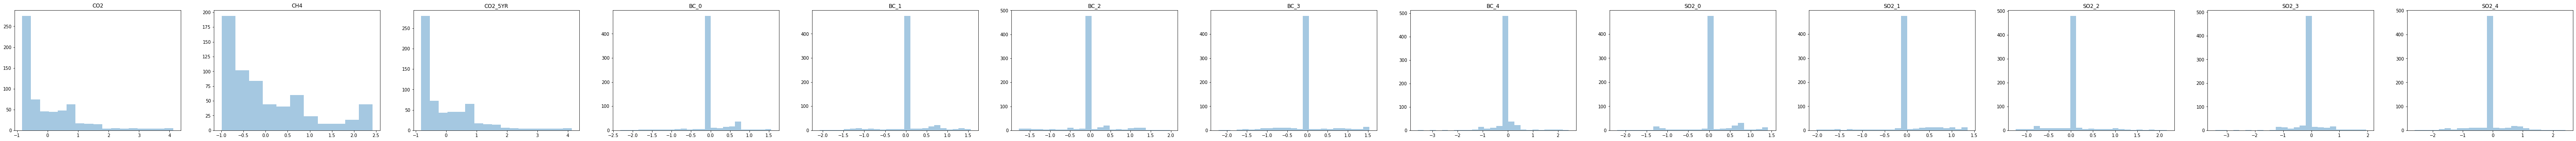

In [9]:
fig, ax = plt.subplots(1, len(X_train.columns), figsize=(8 * len(X_train.columns), 5))
for i, col in enumerate(X_train.columns):
    sns.distplot(X_train[col].values, kde=False, ax=ax[i])
    ax[i].set_title(col)

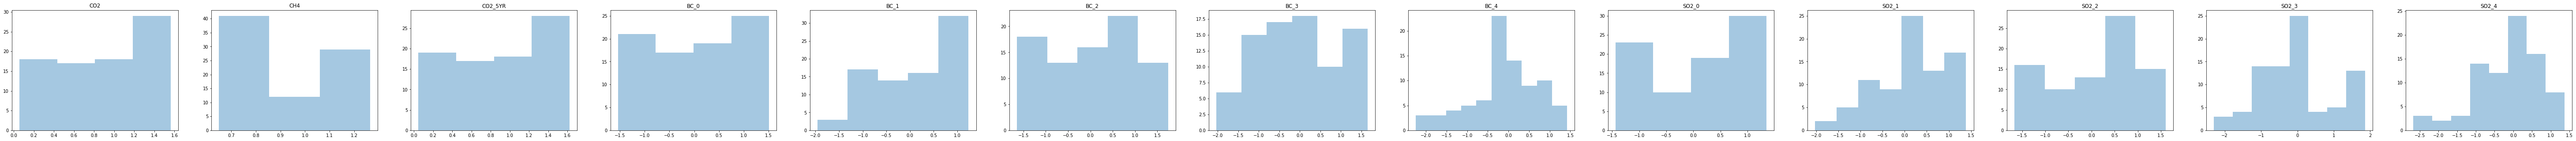

In [10]:
fig, ax = plt.subplots(1, len(X_test.columns), figsize=(8 * len(X_test.columns), 5))
for i, col in enumerate(X_test.columns):
    sns.distplot(X_test[col].values, kde=False, ax=ax[i])
    ax[i].set_title(col)

In [11]:
# Standardize predictand fields
train_pr_mean, train_pr_std = y_train_pr.mean(), y_train_pr.std()
train_pr90_mean, train_pr90_std = y_train_pr90.mean(), y_train_pr90.std()

y_train_pr = (y_train_pr - train_pr_mean) / train_pr_std
y_train_pr90 = (y_train_pr90 - train_pr90_mean) / train_pr90_std

Text(0.5, 1.0, 'Train PR90')

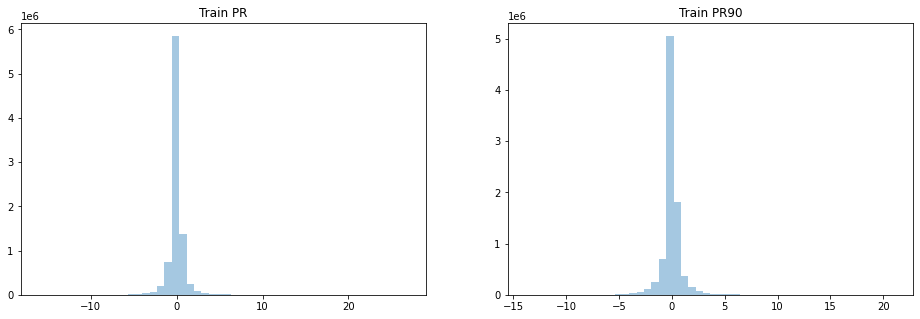

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot(y_train_pr.flatten(), kde=False, ax=ax[0])
ax[0].set_title('Train PR')
sns.distplot(y_train_pr90.flatten(), kde=False, ax=ax[1])
ax[1].set_title('Train PR90')

Text(0.5, 1.0, 'Test PR90')

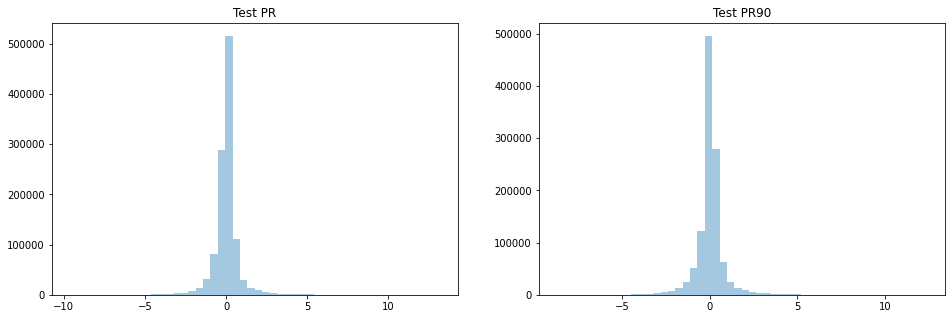

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot((y_test_pr.flatten() - train_pr_mean) / train_pr_std, kde=False, ax=ax[0])
ax[0].set_title('Test PR')
sns.distplot((y_test_pr90.flatten() - train_pr90_mean) / train_pr90_std, kde=False, ax=ax[1])
ax[1].set_title('Test PR90')

### Make a kernel
With gpflow, we need to explicitely construct a kernel instance. This is the real strength of gpflow, we can be much finer in our choices of kernels as we have much more flexibility.

In [15]:
def run_pr_session(kernel):
    np.random.seed(5)
    mean = gpflow.mean_functions.Constant()
    model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                    y_train_pr.astype(np.float64)),
                              kernel=kernel,
                              mean_function=mean)
    # Define optimizer
    opt = gpflow.optimizers.Scipy()

    # Train model
    opt.minimize(model.training_loss,
                 variables=model.trainable_variables,
                 options=dict(disp=True, maxiter=1000))
    
    # predict
    standard_mod_pr = model.predict_y(X_test.values)[0]
    mod_pr = standard_mod_pr * train_pr_std + train_pr_mean
    
    # put output back into pd.DataFrame format for calculating RMSE/plotting
    m_pr = np.reshape(mod_pr, [82, 96, 144])
    m_pr_data = xr.DataArray(m_pr, dims=pr_truth.dims)
    
    def get_rmse(truth, pred):
        weights = np.cos(np.deg2rad(truth.lat))
        return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

    print(f"RMSE at 2050: {get_rmse(pr_truth[31], m_pr_data[31])}")
    print(f"RMSE at 2100: {get_rmse(pr_truth[81], m_pr_data[81])}")
    print(f"RMSE 2045-2055: {get_rmse(pr_truth[26:37], m_pr_data[26:37]).mean()}")
    print(f"RMSE 2090-2100: {get_rmse(pr_truth[71:], m_pr_data[71:]).mean()}")
    print(f"RMSE 2050-2100: {get_rmse(pr_truth[31:], m_pr_data[31:]).mean()}")

In [52]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])
# kernel_BC = gpflow.kernels.Linear(active_dims=[2, 3, 4, 5, 6])
# kernel_SO2 = gpflow.kernels.Linear(active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.Matern32(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

In [53]:
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_pr.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [54]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

      fun: 11469756.201671075
 hess_inv: <20x20 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.32713814e+00, -2.39225207e+01, -7.50473643e+00,  1.81938119e+01,
        1.45194406e+01, -7.54053874e-01, -6.33664150e-01, -2.67000488e+00,
        3.36813307e+00, -1.38034147e+01, -2.39407233e+01, -1.22620406e-01,
       -1.33209777e-02,  2.28614083e-01,  1.54970590e+01,  1.32056228e+01,
        2.89087847e+01, -1.12602189e+01, -6.04752352e+00,  2.63307845e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 260
      nit: 221
   status: 0
  success: True
        x: array([ 4.14750361e+00, -9.91404122e-02,  3.58999970e+00, -2.31794804e+00,
       -2.27210224e+00,  1.38679410e+00, -1.02228239e+00,  1.69400374e+00,
       -2.45715206e+00, -5.20862014e+00, -4.87328843e+00,  3.41448949e+01,
        3.73684176e+01, -2.91103758e+00,  2.89832709e+00,  8.54070426e-02,
        2.95680917e-02, -3.88662759e+00, -1.08406168e-01,  3.16401149e-02])

### PR prediction

In [59]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Linear(active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Linear(active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.Linear(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr_session(kernel)

RMSE at 2050: 0.4395087970543808
RMSE at 2100: 0.5225842992486284
RMSE 2045-2055: 0.5150328502229787
RMSE 2090-2100: 0.5139439584272462
RMSE 2050-2100: 0.5297335606250648


In [60]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.RBF(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr_session(kernel)

RMSE at 2050: 0.43563772403075685
RMSE at 2100: 0.5080726357169606
RMSE 2045-2055: 0.5117489639134554
RMSE 2090-2100: 0.5128173747352606
RMSE 2050-2100: 0.5289052685692605


In [64]:
kernel_CO2 = gpflow.kernels.Matern12(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern12(active_dims=[1])

kernel_BC = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.RBF(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr_session(kernel)

RMSE at 2050: 0.49235740242828746
RMSE at 2100: 0.5443269123296776
RMSE 2045-2055: 0.5145914999601419
RMSE 2090-2100: 0.5226864589175437
RMSE 2050-2100: 0.5335723034251175


In [65]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.Matern32(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr_session(kernel)

RMSE at 2050: 0.4798526534445119
RMSE at 2100: 0.5398603857297569
RMSE 2045-2055: 0.5142823971822856
RMSE 2090-2100: 0.5144898385326271
RMSE 2050-2100: 0.5292066485084035


In [16]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.RBF(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr_session(kernel)

RMSE at 2050: 0.4609306442093797
RMSE at 2100: 0.5364296140376663
RMSE 2045-2055: 0.5099608969299865
RMSE 2090-2100: 0.5026477853344213
RMSE 2050-2100: 0.5239001845459573


----

In [55]:
# predict
standard_mod_pr = model.predict_y(X_test.values)[0]
mod_pr = standard_mod_pr * train_pr_std + train_pr_mean

In [56]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
m_pr = np.reshape(mod_pr, [82, 96, 144])
m_pr_data = xr.DataArray(m_pr, dims=pr_truth.dims)

In [57]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Matern32
# BC / SO2 -> Matern32
# CO2 5Y -> Matern32
print(f"RMSE at 2050: {get_rmse(pr_truth[31], m_pr_data[31])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[81], m_pr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[26:37], m_pr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[71:], m_pr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[31:], m_pr_data[31:]).mean()}")

RMSE at 2050: 0.4979957541535828
RMSE at 2100: 0.5320651537411214
RMSE 2045-2055: 0.5189976474178032
RMSE 2090-2100: 0.5092135742166909
RMSE 2050-2100: 0.533806922361212


In [51]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Linear
# BC / SO2 -> Linear
# CO2 5Y -> RBF
print(f"RMSE at 2050: {get_rmse(pr_truth[31], m_pr_data[31])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[81], m_pr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[26:37], m_pr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[71:], m_pr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[31:], m_pr_data[31:]).mean()}")

RMSE at 2050: 0.4857069134598916
RMSE at 2100: 0.5802478763609331
RMSE 2045-2055: 0.529058297371328
RMSE 2090-2100: 0.512777015952833
RMSE 2050-2100: 0.53438169268069


In [51]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Linear
# BC / SO2 -> Linear
# CO2 5Y -> RBF
print(f"RMSE at 2050: {get_rmse(pr_truth[31], m_pr_data[31])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[81], m_pr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[26:37], m_pr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[71:], m_pr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[31:], m_pr_data[31:]).mean()}")

RMSE at 2050: 0.4857069134598916
RMSE at 2100: 0.5802478763609331
RMSE 2045-2055: 0.529058297371328
RMSE 2090-2100: 0.512777015952833
RMSE 2050-2100: 0.53438169268069


In [45]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Linear
# BC / SO2 -> RBF
# CO2 5Y -> Linear
print(f"RMSE at 2050: {get_rmse(pr_truth[31], m_pr_data[31])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[81], m_pr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[26:37], m_pr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[71:], m_pr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[31:], m_pr_data[31:]).mean()}")

RMSE at 2050: 0.4752251536248575
RMSE at 2100: 0.5332080975420984
RMSE 2045-2055: 0.5425731468995724
RMSE 2090-2100: 0.514468485546158
RMSE 2050-2100: 0.5371639594777171


In [39]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> RBF
# BC / SO2 -> Linear
# CO2 5Y -> Linear
print(f"RMSE at 2050: {get_rmse(pr_truth[31], m_pr_data[31])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[81], m_pr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[26:37], m_pr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[71:], m_pr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[31:], m_pr_data[31:]).mean()}")

RMSE at 2050: 0.4449411807235437
RMSE at 2100: 0.5357413006468392
RMSE 2045-2055: 0.5183801314883207
RMSE 2090-2100: 0.5132400896394358
RMSE 2050-2100: 0.5289954902613462


In [33]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Linear
# BC / SO2 -> Linear
# CO2 5Y -> Linear
print(f"RMSE at 2050: {get_rmse(pr_truth[31], m_pr_data[31])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[81], m_pr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[26:37], m_pr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[71:], m_pr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[31:], m_pr_data[31:]).mean()}")

RMSE at 2050: 0.4847030817845484
RMSE at 2100: 0.5832920264324384
RMSE 2045-2055: 0.5511422333293571
RMSE 2090-2100: 0.5401937951055739
RMSE 2050-2100: 0.5596103610208584


In [27]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> RBF
# BC / SO2 -> RBF
# CO2 5Y -> RBF
print(f"RMSE at 2050: {get_rmse(pr_truth[31], m_pr_data[31])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[81], m_pr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[26:37], m_pr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[71:], m_pr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[31:], m_pr_data[31:]).mean()}")

RMSE at 2050: 0.4903502352225752
RMSE at 2100: 0.6004807405431531
RMSE 2045-2055: 0.5032953955180172
RMSE 2090-2100: 0.5254103763639805
RMSE 2050-2100: 0.534850963901171


In [21]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Linear / Matern32
# BC / SO2 -> Linear
# CO2 5Y -> Linear
print(f"RMSE at 2050: {get_rmse(pr_truth[31], m_pr_data[31])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[81], m_pr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[26:37], m_pr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[71:], m_pr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[31:], m_pr_data[31:]).mean()}")

RMSE at 2050: 0.43756474182616817
RMSE at 2100: 0.5502497486049651
RMSE 2045-2055: 0.5166948489299782
RMSE 2090-2100: 0.5147755914584772
RMSE 2050-2100: 0.5276341914517668


### PR90 prediction

In [18]:
def run_pr90_session(kernel):
    np.random.seed(5)
    mean = gpflow.mean_functions.Constant()
    model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                    y_train_pr.astype(np.float64)),
                              kernel=kernel,
                              mean_function=mean)
    # Define optimizer
    opt = gpflow.optimizers.Scipy()

    # Train model
    opt.minimize(model.training_loss,
                 variables=model.trainable_variables,
                 options=dict(disp=True, maxiter=1000))
    
    # predict
    standard_mod_pr90 = model.predict_y(X_test.values)[0]
    mod_pr90 = standard_mod_pr90 * train_pr90_std + train_pr90_mean

    # put output back into pd.DataFrame format for calculating RMSE/plotting
    m_pr90 = np.reshape(mod_pr90, [82, 96, 144])
    m_pr90_data = xr.DataArray(m_pr90, dims=pr90_truth.dims)

    def get_rmse(truth, pred):
        weights = np.cos(np.deg2rad(truth.lat))
        return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

    print(f"RMSE at 2050: {get_rmse(pr90_truth[31], m_pr90_data[31])}")
    print(f"RMSE at 2100: {get_rmse(pr90_truth[81], m_pr90_data[81])}")
    print(f"RMSE 2045-2055: {get_rmse(pr90_truth[26:37], m_pr90_data[26:37]).mean()}")
    print(f"RMSE 2090-2100: {get_rmse(pr90_truth[71:], m_pr90_data[71:]).mean()}")
    print(f"RMSE 2050-2100: {get_rmse(pr90_truth[31:], m_pr90_data[31:]).mean()}")

In [62]:
kernel_CO2 = gpflow.kernels.Linear(active_dims=[0])
kernel_CH4 = gpflow.kernels.Linear(active_dims=[1])

kernel_BC = gpflow.kernels.Linear(active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Linear(active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.Linear(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr90_session(kernel)

RMSE at 2050: 1.4402196954324407
RMSE at 2100: 1.7400945375825239
RMSE 2045-2055: 1.606982353161652
RMSE 2090-2100: 1.5702750817484323
RMSE 2050-2100: 1.6224114540658587


In [19]:
kernel_CO2 = gpflow.kernels.RBF(active_dims=[0])
kernel_CH4 = gpflow.kernels.RBF(active_dims=[1])

kernel_BC = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.RBF(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr90_session(kernel)

RMSE at 2050: 1.4878882851923865
RMSE at 2100: 1.7948241533334068
RMSE 2045-2055: 1.5071030160277898
RMSE 2090-2100: 1.5425265689550824
RMSE 2050-2100: 1.5821840646871679


In [20]:
kernel_CO2 = gpflow.kernels.RBF(active_dims=[0])
kernel_CH4 = gpflow.kernels.RBF(active_dims=[1])

kernel_BC = gpflow.kernels.Linear(active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Linear(active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.Linear(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr90_session(kernel)

RMSE at 2050: 1.3608285939938918
RMSE at 2100: 1.6359794715162888
RMSE 2045-2055: 1.537224658974123
RMSE 2090-2100: 1.539418546067914
RMSE 2050-2100: 1.576473039227091


In [21]:
kernel_CO2 = gpflow.kernels.Linear(active_dims=[0])
kernel_CH4 = gpflow.kernels.Linear(active_dims=[1])

kernel_BC = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.Linear(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr90_session(kernel)

RMSE at 2050: 1.4146328203108467
RMSE at 2100: 1.6173416820107085
RMSE 2045-2055: 1.586373087886467
RMSE 2090-2100: 1.5169405846338249
RMSE 2050-2100: 1.5728413283070581


In [22]:
kernel_CO2 = gpflow.kernels.Linear(active_dims=[0])
kernel_CH4 = gpflow.kernels.Linear(active_dims=[1])

kernel_BC = gpflow.kernels.Linear(active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Linear(active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.RBF(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr90_session(kernel)

RMSE at 2050: 1.4721462509661474
RMSE at 2100: 1.7392924657567348
RMSE 2045-2055: 1.5604173030482473
RMSE 2090-2100: 1.523058245827306
RMSE 2050-2100: 1.5811749282071996


In [23]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.Matern32(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr90_session(kernel)

RMSE at 2050: 1.5154039875565204
RMSE at 2100: 1.6169296479474977
RMSE 2045-2055: 1.5399235435133982
RMSE 2090-2100: 1.5247976404699777
RMSE 2050-2100: 1.585772804586575


In [24]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Linear(active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Linear(active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.Linear(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr90_session(kernel)

RMSE at 2050: 1.347477355321319
RMSE at 2100: 1.5990643552904544
RMSE 2045-2055: 1.5284581506741595
RMSE 2090-2100: 1.5375014937437295
RMSE 2050-2100: 1.5747109745592025


In [25]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.RBF(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr90_session(kernel)

RMSE at 2050: 1.3389730827827035
RMSE at 2100: 1.5579155458723177
RMSE 2045-2055: 1.5218136293305649
RMSE 2090-2100: 1.5270127911192068
RMSE 2050-2100: 1.570096026032465


In [26]:
kernel_CO2 = gpflow.kernels.Matern12(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern12(active_dims=[1])

kernel_BC = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.RBF(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr90_session(kernel)

RMSE at 2050: 1.4973246150157784
RMSE at 2100: 1.6483588090890295
RMSE 2045-2055: 1.5282177979393845
RMSE 2090-2100: 1.541642957285366
RMSE 2050-2100: 1.573794219888242


In [27]:
kernel_CO2 = gpflow.kernels.Matern12(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern12(active_dims=[1])

kernel_BC = gpflow.kernels.Linear(active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Linear(active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.RBF(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr90_session(kernel)

RMSE at 2050: 1.3350403163699456
RMSE at 2100: 1.6329052218156501
RMSE 2045-2055: 1.5140152987571402
RMSE 2090-2100: 1.5423148580791497
RMSE 2050-2100: 1.5683716651325215


In [28]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.RBF(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr90_session(kernel)

RMSE at 2050: 1.4088853851304677
RMSE at 2100: 1.6269930979824383
RMSE 2045-2055: 1.516192876741296
RMSE 2090-2100: 1.4976873336325554
RMSE 2050-2100: 1.5548985842457208


In [29]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.RBF(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.Matern32(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

run_pr90_session(kernel)

RMSE at 2050: 1.4642938793885556
RMSE at 2100: 1.6395445004131313
RMSE 2045-2055: 1.5291049473552505
RMSE 2090-2100: 1.5281376319388955
RMSE 2050-2100: 1.5674176611892907


---

In [ ]:
# predict
standard_mod_pr90 = model.predict_y(X_test.values)[0]
mod_pr90 = standard_mod_pr90 * train_pr90_std + train_pr90_mean

In [210]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
m_pr90 = np.reshape(mod_pr90, [82, 96, 144])
m_pr90_data = xr.DataArray(m_pr90, dims=pr90_truth.dims)

In [211]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# CO2 / CH4 -> Linear
# BC / SO2 -> Linear
# CO2 5Y -> Linear
print(f"RMSE at 2050: {get_rmse(pr90_truth[31], m_pr90_data[31])}")
print(f"RMSE at 2100: {get_rmse(pr90_truth[81], m_pr90_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(pr90_truth[26:37], m_pr90_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr90_truth[71:], m_pr90_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr90_truth[31:], m_pr90_data[31:]).mean()}")

RMSE at 2050: 0.36520056305913046
RMSE at 2100: 0.3058833059031739
RMSE 2045-2055: 0.3799708050993382
RMSE 2090-2100: 0.3789536163233654
RMSE 2050-2100: 0.3857957679646913
